# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [1]:
import numpy as np
import pandas as pd 

from scipy.io import loadmat
from deepymod.DeepMoD import DeepMoD
from deepymod.library_functions import library_2Din_1Dout
from deepymod.utilities import library_matrix_mat, print_PDE

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

np.random.seed(42)  # setting seed for randomisation

## Prepare the data

Next, we prepare the dataset.

In [2]:
data = loadmat('Diffusion_bc.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((51,101,3))

x_v= usol[:,:,0]
t_v = usol[:,:,1]
y_v = usol[:,:,2]

Next we plot the dataset for three different time-points

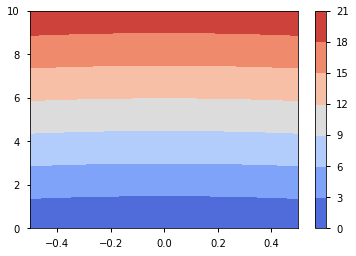

In [14]:
plt.contourf(x_v, t_v, y_v, cmap='coolwarm')
plt.colorbar()

In [15]:
x_v.shape

(51, 101)

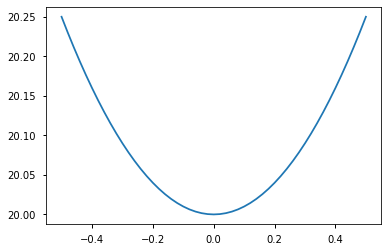

In [16]:
frame = 100
plt.plot(x_v[:, frame], y_v[:, frame])

We flatten it to give it the right dimensions for feeding it to the network:

In [17]:
X = np.transpose((t_v.flatten(),x_v.flatten()))
y = y_v.reshape((y_v.size, 1))

In [27]:
y.shape

(5151, 1)

(202, 1)

We select the noise level we add to the data-set

In [18]:
noise_level = 0.1

In [19]:
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

Select the number of samples:

In [20]:
number_of_samples = 2000

In [21]:
idx = np.random.permutation(y.size)
X_train = X[idx, :][:number_of_samples]
y_train = y_noisy[idx, :][:number_of_samples]

In [44]:
X_BC = np.where(np.logical_or(X_train[:, 1] == X[:, 1].min(), X_train[:, 1] == X[:, 1].max()))[0][:, None]

In [45]:
X_BC.shape

(77, 1)

So we have 77 elements on the boundary.

## Configure the neural network

Next we define the architecture and strength of the $L_1$ penalty for the neural network.
Note that in this example have three input channels in this example: {x,y,t}

In [51]:
config = {'layers': [2, 20, 20, 20, 20, 20, 1], 'lambda': 10**-6}

DeepMoD accepts any arbitrary library function and any options for it can be given through *the library_config*. The library function for this example accepts a maximum order for the polynomial and derivative terms. DeepMoD also needs to know the total number of terms upfront. We can calculate that by making a list of the polynomial and derivative terms and getting all the terms by feeding them into the library_matrix_mat function. Its output will be used later to print the found PDE.

In [52]:
u = ['1', 'u']
du = ['1', 'u_{x}', 'u_{y}','u_{xx}', 'u_{yy}','u_{xy}']
coeffs_list = library_matrix_mat(u, du)
print(coeffs_list)
library_config = {'total_terms': 12, 'deriv_order': 2, 'poly_order': 1}

['1', 'u_{x}', 'u_{y}', 'u_{xx}', 'u_{yy}', 'u_{xy}', 'u', 'uu_{x}', 'uu_{y}', 'uu_{xx}', 'uu_{yy}', 'uu_{xy}']


Next we set the training options. Usually we only change the maximum iterations and the grad_tol, which sets the convergence criterion;

In [53]:
train_opts = {'max_iterations': 50000, 'grad_tol':10**-7, 'learning_rate': 0.002, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8}

The last configuration we need to fill is the ouput_opts. It contains an output_directory and X_predict field. We've build a custom tensorboard so you can follow the progress of the run.  Output_directory sets where the files are saved, then simply run 

`tensorboard --logdir $[OUTPUT_DIRECTORY]`

in a terminal to open tensorboard. It shows the value of the coefficients, scaled coefficients and all possible costs. Note that the runs are timestamped in output_directory, so you'll have to add it! We can also use the output of tensorboard to analyze deepmod after. We show this below. The last option is X_predict. As DeepMoD also denoises the data, use this option to denoise some dataset X after DeepMoD has converged.

In [54]:
output_opts = {'output_directory': 'output/AD/', 'X_predict': X}

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We also need to specify which library function we wish to use. You can build any library you want and just pass is through this command:

In [55]:
sparse_vectors, denoised = DeepMoD(X_train, y_train, config, library_1Din_1Dout, library_config, train_opts, output_opts, X_BC)

Epoch | Total loss | Loss gradient | MSE | PI | L1 


InvalidArgumentError: data.shape must start with partitions.shape, got data.shape = [2000,6], partitions.shape = [2000,12]
	 [[node Creating_library/DynamicPartition (defined at /Users/gert-janboth/Documents/PhD/Software/DeePyMoD/src/deepymod/graphs.py:35) ]]

Caused by op 'Creating_library/DynamicPartition', defined at:
  File "/anaconda3/envs/probai/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/probai/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/probai/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/anaconda3/envs/probai/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/anaconda3/envs/probai/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-c4d929b5e584>", line 1, in <module>
    sparse_vectors, denoised = DeepMoD(X_train, y_train, config, library_2Din_1Dout, library_config, train_opts, output_opts, X_BC)
  File "/Users/gert-janboth/Documents/PhD/Software/DeePyMoD/src/deepymod/DeepMoD.py", line 26, in DeepMoD
    coeff_list, coeff_scaled_list, weights, biases = PINN(data, target, mask, internal_config, library_function, library_config, train_opts, output_opts, BC_mask)
  File "/Users/gert-janboth/Documents/PhD/Software/DeePyMoD/src/deepymod/PINN.py", line 11, in PINN
    graph = PINN_graph(config, library_function, library_config)
  File "/Users/gert-janboth/Documents/PhD/Software/DeePyMoD/src/deepymod/graphs.py", line 35, in PINN_graph
    theta_split = [tf.dynamic_partition(theta, coeff_mask, 2)[1] for coeff_mask in tf.unstack(sparsity_mask, axis=2, num=len(coeff_list))]
  File "/Users/gert-janboth/Documents/PhD/Software/DeePyMoD/src/deepymod/graphs.py", line 35, in <listcomp>
    theta_split = [tf.dynamic_partition(theta, coeff_mask, 2)[1] for coeff_mask in tf.unstack(sparsity_mask, axis=2, num=len(coeff_list))]
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 664, in dynamic_partition
    num_partitions=num_partitions, name=name)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/anaconda3/envs/probai/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): data.shape must start with partitions.shape, got data.shape = [2000,6], partitions.shape = [2000,12]
	 [[node Creating_library/DynamicPartition (defined at /Users/gert-janboth/Documents/PhD/Software/DeePyMoD/src/deepymod/graphs.py:35) ]]


Show final result:

In [32]:
u = ['1', 'u']
du = ['1', 'u_{x}', 'u_{y}','u_{xx}', 'u_{yy}','u_{xy}']
coeffs_list = library_matrix_mat(u, du)

print('Inferred equation:')
print_PDE(sparse_vectors[0], coeffs_list, PDE_term='u_t')

Inferred equation:
u_t = 0.254u_{x} + 0.495u_{y} + 0.498u_{xx} + 0.522u_{yy}


Plot the 'Ground truth', 'Noisy' and 'Reconstructed/Denoised' solution

In [22]:
X_predict = X[(X[:,0]==5.0) | (X[:,0]==9.0) | (X[:,0]==7.0), :]

In [23]:
data_dict = {'x_grid': X[:,1],'y_grid': X[:,2], 't_grid': X[:,0], 'ground_truth': np.squeeze(y), 'noisy': np.squeeze(y_noisy)}
df = pd.DataFrame(data_dict)
for key in df:
    df[key] = np.squeeze(df[key])
data = pd.DataFrame(df)

In [24]:
data_dict_denoised = {'x_grid': X[:,1],'y_grid': X[:,2], 't_grid': X[:,0], 'denoised': np.squeeze(denoised)}
df_dn = pd.DataFrame(data_dict_denoised)
for key in df_dn:
    df_dn[key] = np.squeeze(df_dn[key])
data_denoised = pd.DataFrame(df_dn)

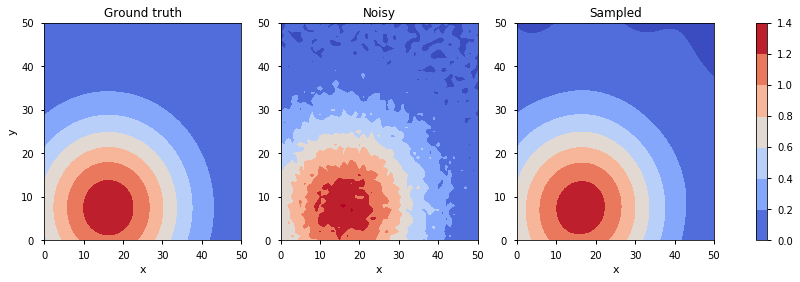

In [31]:
time1 = 7.0

vmin = np.min(data[data['t_grid'] == time1]['ground_truth'])
vmax = np.max(data[data['t_grid'] == time1]['ground_truth'])

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im1 = axes[0].contourf(pd.pivot_table(data[data['t_grid'] == time1],index='y_grid', columns='x_grid', values='ground_truth'), cmap='coolwarm',vmin=vmin, vmax=vmax)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Ground truth')

im2 = axes[1].contourf(pd.pivot_table(data[data['t_grid'] == time1],index='y_grid', columns='x_grid', values='noisy'), cmap='coolwarm', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

im3 = axes[2].contourf(pd.pivot_table(data_denoised[data_denoised['t_grid'] == time1],index='y_grid', columns='x_grid', values='denoised'), cmap='coolwarm', vmin=vmin, vmax=vmax)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()